# Explore here

## Step 1: Problem statement and data collection

Problem statement: given sociodemographic and health resource data have been collected by county in the United States, find out if there is any relationship between health resources and sociodemographic data

In [71]:
# Import dataset to start working with it
import pandas as pd

raw_data = pd.read_csv("../data/raw/demographic_health_data.csv", sep=",")

## Step 2: Exploration and data cleaning

In [72]:
print(f"Raw data shape: {raw_data.shape}")
print(raw_data.info(show_counts=True))

# .info won't make it so easy to find nulls now that we're looking at larger datasets, so let's try other methods...
missing_summary = (
    raw_data.isna()
    .sum()  # raw counts
    .to_frame("null_count")
    .assign(null_pct=lambda s: s["null_count"].div(len(raw_data)) * 100)
    .query("null_count > 0")  # keep only problem columns
    .sort_values("null_pct", ascending=False)
)

missing_summary.head(10).style.bar("null_pct")

Raw data shape: (3140, 108)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


,null_count,null_pct


Doesn't look as though any of our columns have missing data at all, which simplifies matters.

I'm going to make the simplified assumption that any rows which have identical values across all columns are duplicates of the same county, rather than being actually-distinct counties with so-similar statistics.
I'm also going to make the assumption that FIPS codes are unique by county, and once a first instance is found of a row with a FIPS code, subsequent rows using the same code are to be treated as duped or invalid data. 

In [73]:
raw_data.drop_duplicates(inplace=True)
raw_data = raw_data.drop_duplicates(subset=["fips"], keep="first", ignore_index=True)


print(raw_data.shape)
raw_data.head()
raw_data.info()

(3140, 108)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


### Removing irrelevant data:

- Based on discussion with professor, my instinct is correct that FIPS codes in this context operate as categorical rather than numerical variables.  With only 3000 rows, that's not likely enough data to effectively train the model at so-granular a level as county; sounds like we'd be better off going coarser grouping by state-level rather than county-level.

In [74]:
# remove data considered irrelevant
raw_data.drop(["fips", "CNTY_FIPS", "COUNTY_NAME", "STATE_FIPS"], axis=1, inplace=True)


raw_data.head()

,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,3038,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,7474,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [75]:
# --- load both artefacts -----------------------------------------------------
dict_df = pd.read_csv("../data/data_dict.csv", sep=",")

# --- pull the “authoritative” list of names from the first column -----------
# • .iloc[:, 0]  → first column, regardless of its header
# • .astype(str).str.strip()  → normalise just in case there’s
#   stray whitespace or non-string types
dict_cols = dict_df.iloc[:, 0].astype(str).str.strip()
dict_index = pd.Index(dict_cols)

# --- 1.  Columns that appear in the data set but are NOT in the dictionary --
missing_from_dictionary = raw_data.columns.difference(dict_index, sort=False)

# --- 2.  (optional) Dictionary entries that don’t exist in the data set -----
unused_dictionary_rows = dict_index.difference(raw_data.columns, sort=False)

print("Data columns lacking a dictionary entry:", list(missing_from_dictionary))
print("Dictionary rows that map to no data:", list(unused_dictionary_rows))


Data columns lacking a dictionary entry: ['19-Oct', 'POP_ESTIMATE_2018', 'Median_Household_Income_2018', 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Total Population', 'STATE_NAME']
Dictionary rows that map to no data: ['fips', "10-19'", 'STATE_FIPS', 'nan']


Looks like the original dataset has a misnamed column, likely at some point mangled by MS Excel: "19-Oct" is an interpretation of "19-10," and this column is immediately between the 0-9 age-range column and the 10-19 y/o % of total pop column.  Shall rename it to 10-19 instead.
The rest of the columns appear intuitive-enough and plausibly relevant-enough to keep.

In [76]:
raw_data = raw_data.rename(columns={"19-Oct": "10-19"})

## Step 3: Analysis of univariate variables
### categorical variables
Categorical, non-numeric variables in this dataframe include: county-level fips (which we just deleted), STATE_NAME, and Urban_rural_code

In [77]:
categorical_variables = [
    "STATE_NAME",
    "Urban_rural_code",
]

for each_categorical_variable in categorical_variables:
    print(f"\n\t{each_categorical_variable}s:")
    for each_possible_value in sorted(
        raw_data[f"{each_categorical_variable}"].unique()
    ):
        print(each_possible_value)


	STATE_NAMEs:
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming

	Urban_rural_codes:
1
2
3
4
5
6


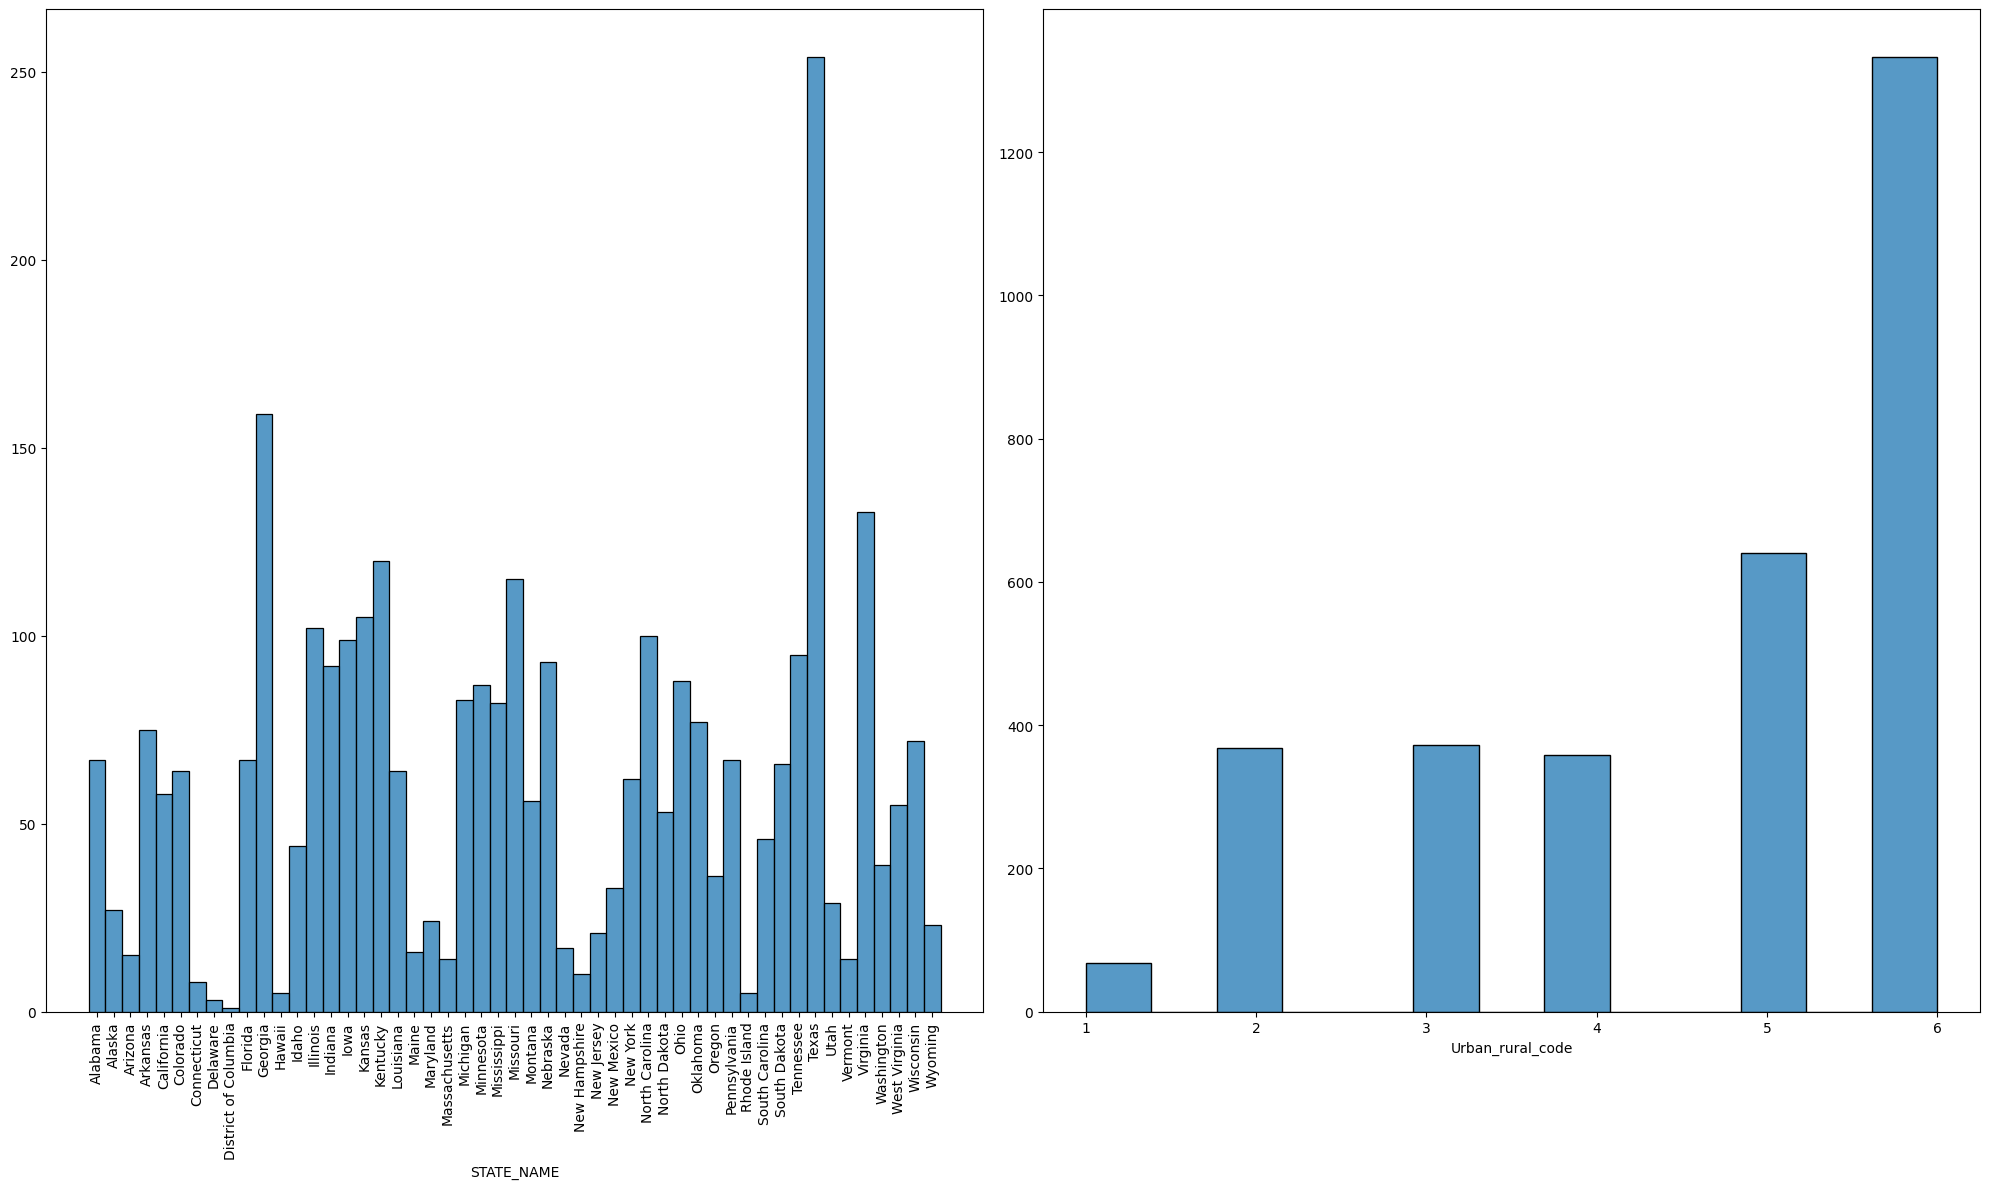

In [78]:
# histogram-plot each categorical variable

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(1, 2, figsize=(20, 12))

# Create a multiple histogram
sns.histplot(ax=axis[0], data=raw_data, x="STATE_NAME", bins="auto").set(ylabel=None)
axis[0].tick_params(axis="x", rotation=90)
sns.histplot(ax=axis[1], data=raw_data, x="Urban_rural_code").set(ylabel=None)

# Adjust the layout
plt.tight_layout()


# Show the plot
plt.show()

- We have many more counties worth of data available for some states than others; almost all are between 100 and 350 but the extrmes range from the tens all the way up to over 450 
- Despite data dictionary including codings above 6 we don't appear to have any instances of them in the data.
- Most counties have populations between 2,500 and 19,999 

### numeric variables

Numerical, non-categorical variables in the dataset: vast majority of them, just need to mask out a couple of categorical ones

In [79]:
numeric_variables = raw_data.columns[~raw_data.columns.isin(categorical_variables)]
print(numeric_variables)

Index(['TOT_POP', '0-9', '0-9 y/o % of total pop', '10-19',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop', '40-49',
       ...
       'COPD_Upper 95% CI', 'COPD_number', 'diabetes_prevalence',
       'diabetes_Lower 95% CI', 'diabetes_Upper 95% CI', 'diabetes_number',
       'CKD_prevalence', 'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number'],
      dtype='object', length=102)


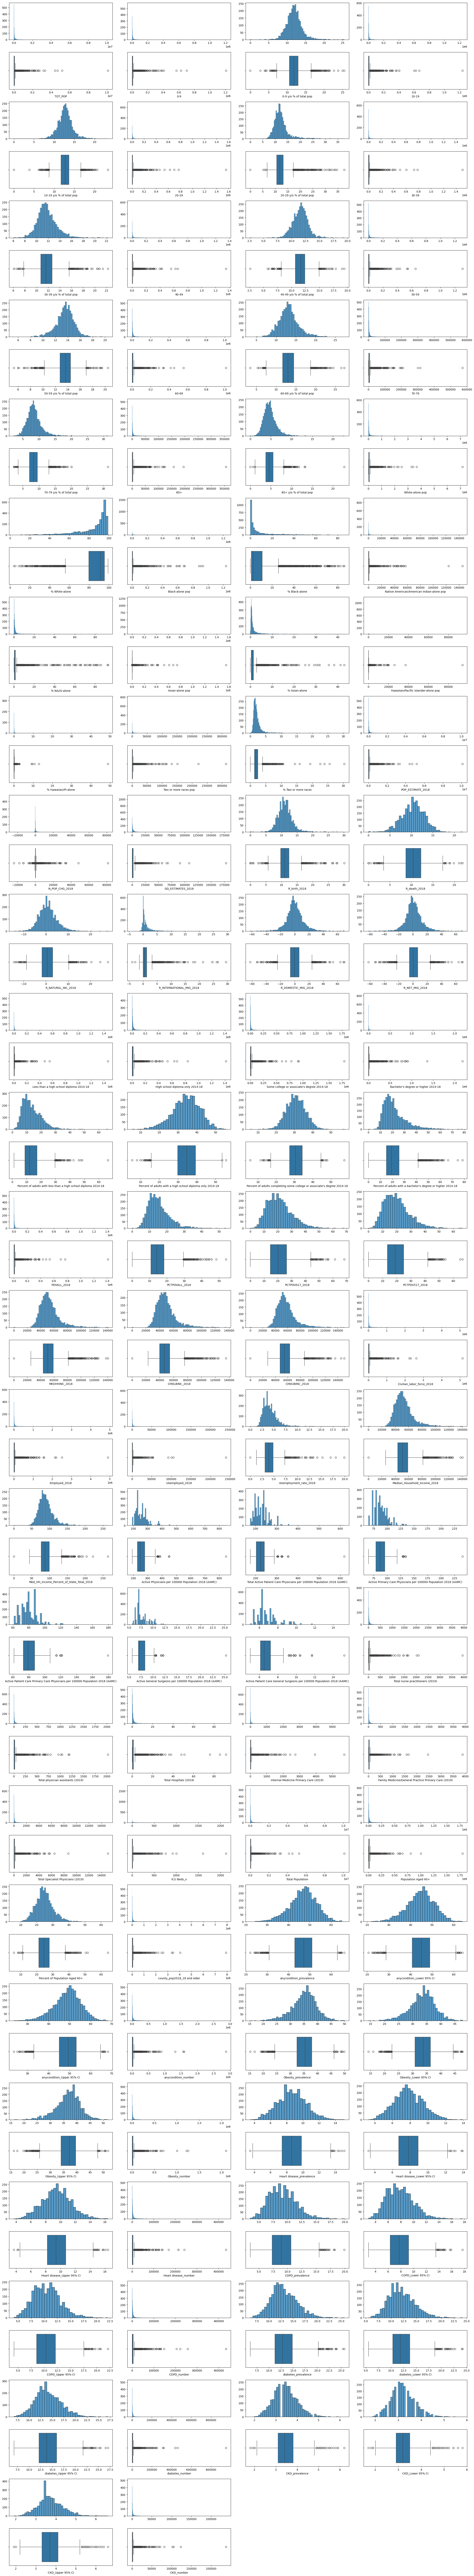

In [80]:
import math

cols_per_row = 4
num_vars = len(numeric_variables)
num_cols = cols_per_row
num_var_rows = math.ceil(num_vars / cols_per_row)
num_rows = 2 * num_var_rows  # 2 rows per variable group (hist + box)

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(6 * num_cols, 2.5 * num_rows),  # Adjusts spacing
    squeeze=False,
)

# Plot
for i, var in enumerate(numeric_variables):
    row_group = i // cols_per_row
    col = i % cols_per_row

    # Histogram in upper of the two rows for this group
    sns.histplot(ax=axes[2 * row_group][col], data=raw_data, x=var).set(
        xlabel=None, ylabel=None
    )

    # Boxplot in lower of the two rows for this group
    sns.boxplot(ax=axes[2 * row_group + 1][col], data=raw_data, x=var)

# Turn off any unused subplots
for row in axes:
    for ax in row:
        if not ax.has_data():
            ax.set_visible(False)

plt.tight_layout()
plt.show()

From this it looks like:
- plots showing number of people in each age/generation bracket show most counties have a have at most a few hundred thousand people in each age bracket, but then there are outlier counties with over a million (1e6) or a million and a half people in that age bracket.
- proportiohnally, most counties have about even proportions of most age brackets, about 10% or so. Exceptions include a handful of percentage points more 30-39 year olds and a handful of percentage points fewer of older people 70-79 and yet fewer 80+
- Would be curious to hear whether the county with (outlier) zero unemployment did indeed accomplish that or whether it's inaccurate & should be dropped from the dataset.
- Skimming these plots is the point at which I discovered our dataset does include county name and state name for each row.  That isn't shown in the data dictinary.  So I went back up this notebook to delete the county name for the same reason we deleted the county-level fips code earlier, and delete state-level fips code in favor of state name -- both for legibility and to make it that much clearer it's a categorical variable we will factorize later instead of being a numerical veriable.  Also moved my "does the data dictionary really tell us about all the columns?" investigation further up this notebook.

## Step 4: Analysis of multivariate variables
### Numerical-numerical analysis
Am curious to see whether/how there are correlations between age & how long people stayed on the phone, or age & how many employees they have.


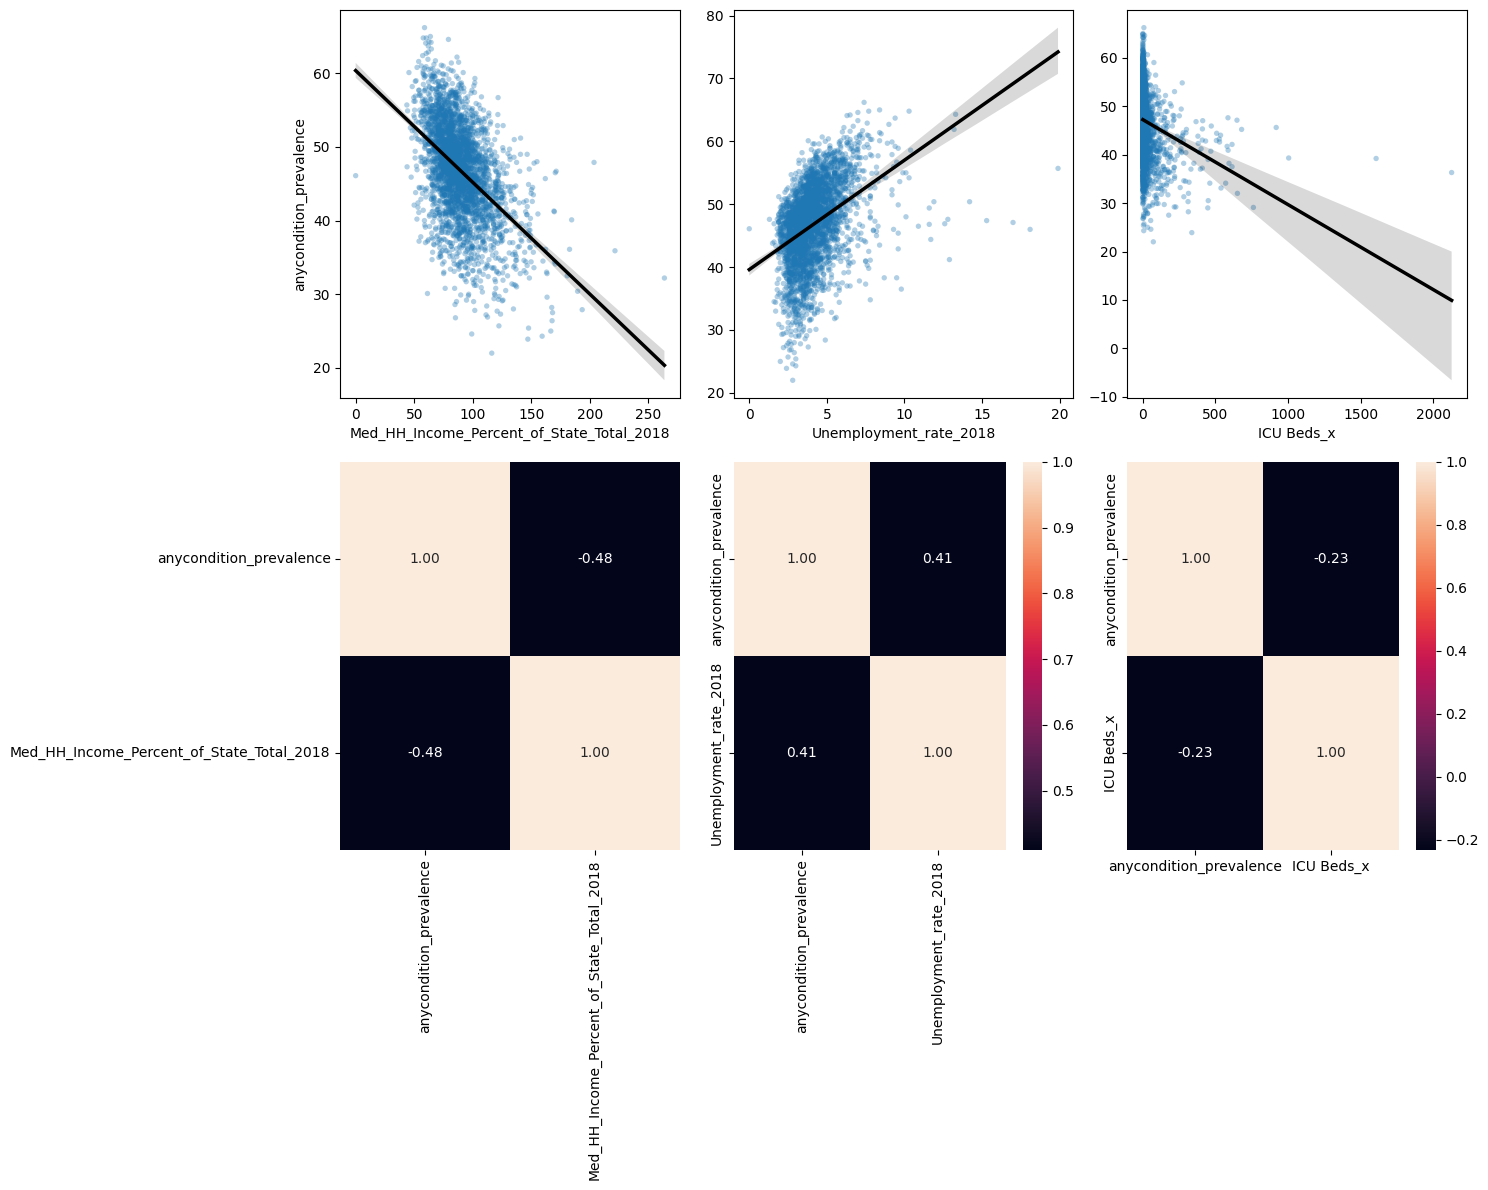

In [81]:
fig, axis = plt.subplots(2, 3, figsize=(15, 12))

# Create a multiple scatter diagram
common_scatter = {"s": 15, "alpha": 0.35, "edgecolor": "none"}
common_line = {"color": "black", "lw": 2.5, "zorder": 5}

sns.regplot(
    ax=axis[0, 0],
    data=raw_data,
    x="Med_HH_Income_Percent_of_State_Total_2018",
    y="anycondition_prevalence",
    scatter_kws=common_scatter,
    line_kws=common_line,
)
sns.heatmap(
    raw_data[
        ["anycondition_prevalence", "Med_HH_Income_Percent_of_State_Total_2018"]
    ].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 0],
    cbar=False,
)

sns.regplot(
    ax=axis[0, 1],
    data=raw_data,
    x="Unemployment_rate_2018",
    y="anycondition_prevalence",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["anycondition_prevalence", "Unemployment_rate_2018"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 1],
)

sns.regplot(
    ax=axis[0, 2],
    data=raw_data,
    x="ICU Beds_x",
    y="anycondition_prevalence",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["anycondition_prevalence", "ICU Beds_x"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 2],
)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

I had guessed that earning more money corresponds to lower prevalence of unwanted medical health conditions, that higher unemployment corresponds to higher prevalence of such conditions, and that more total ICU beds available leads to lower prevalnence of medical conditions.  the charts make each of these guesses look correct.

### categorical-categorical analysis

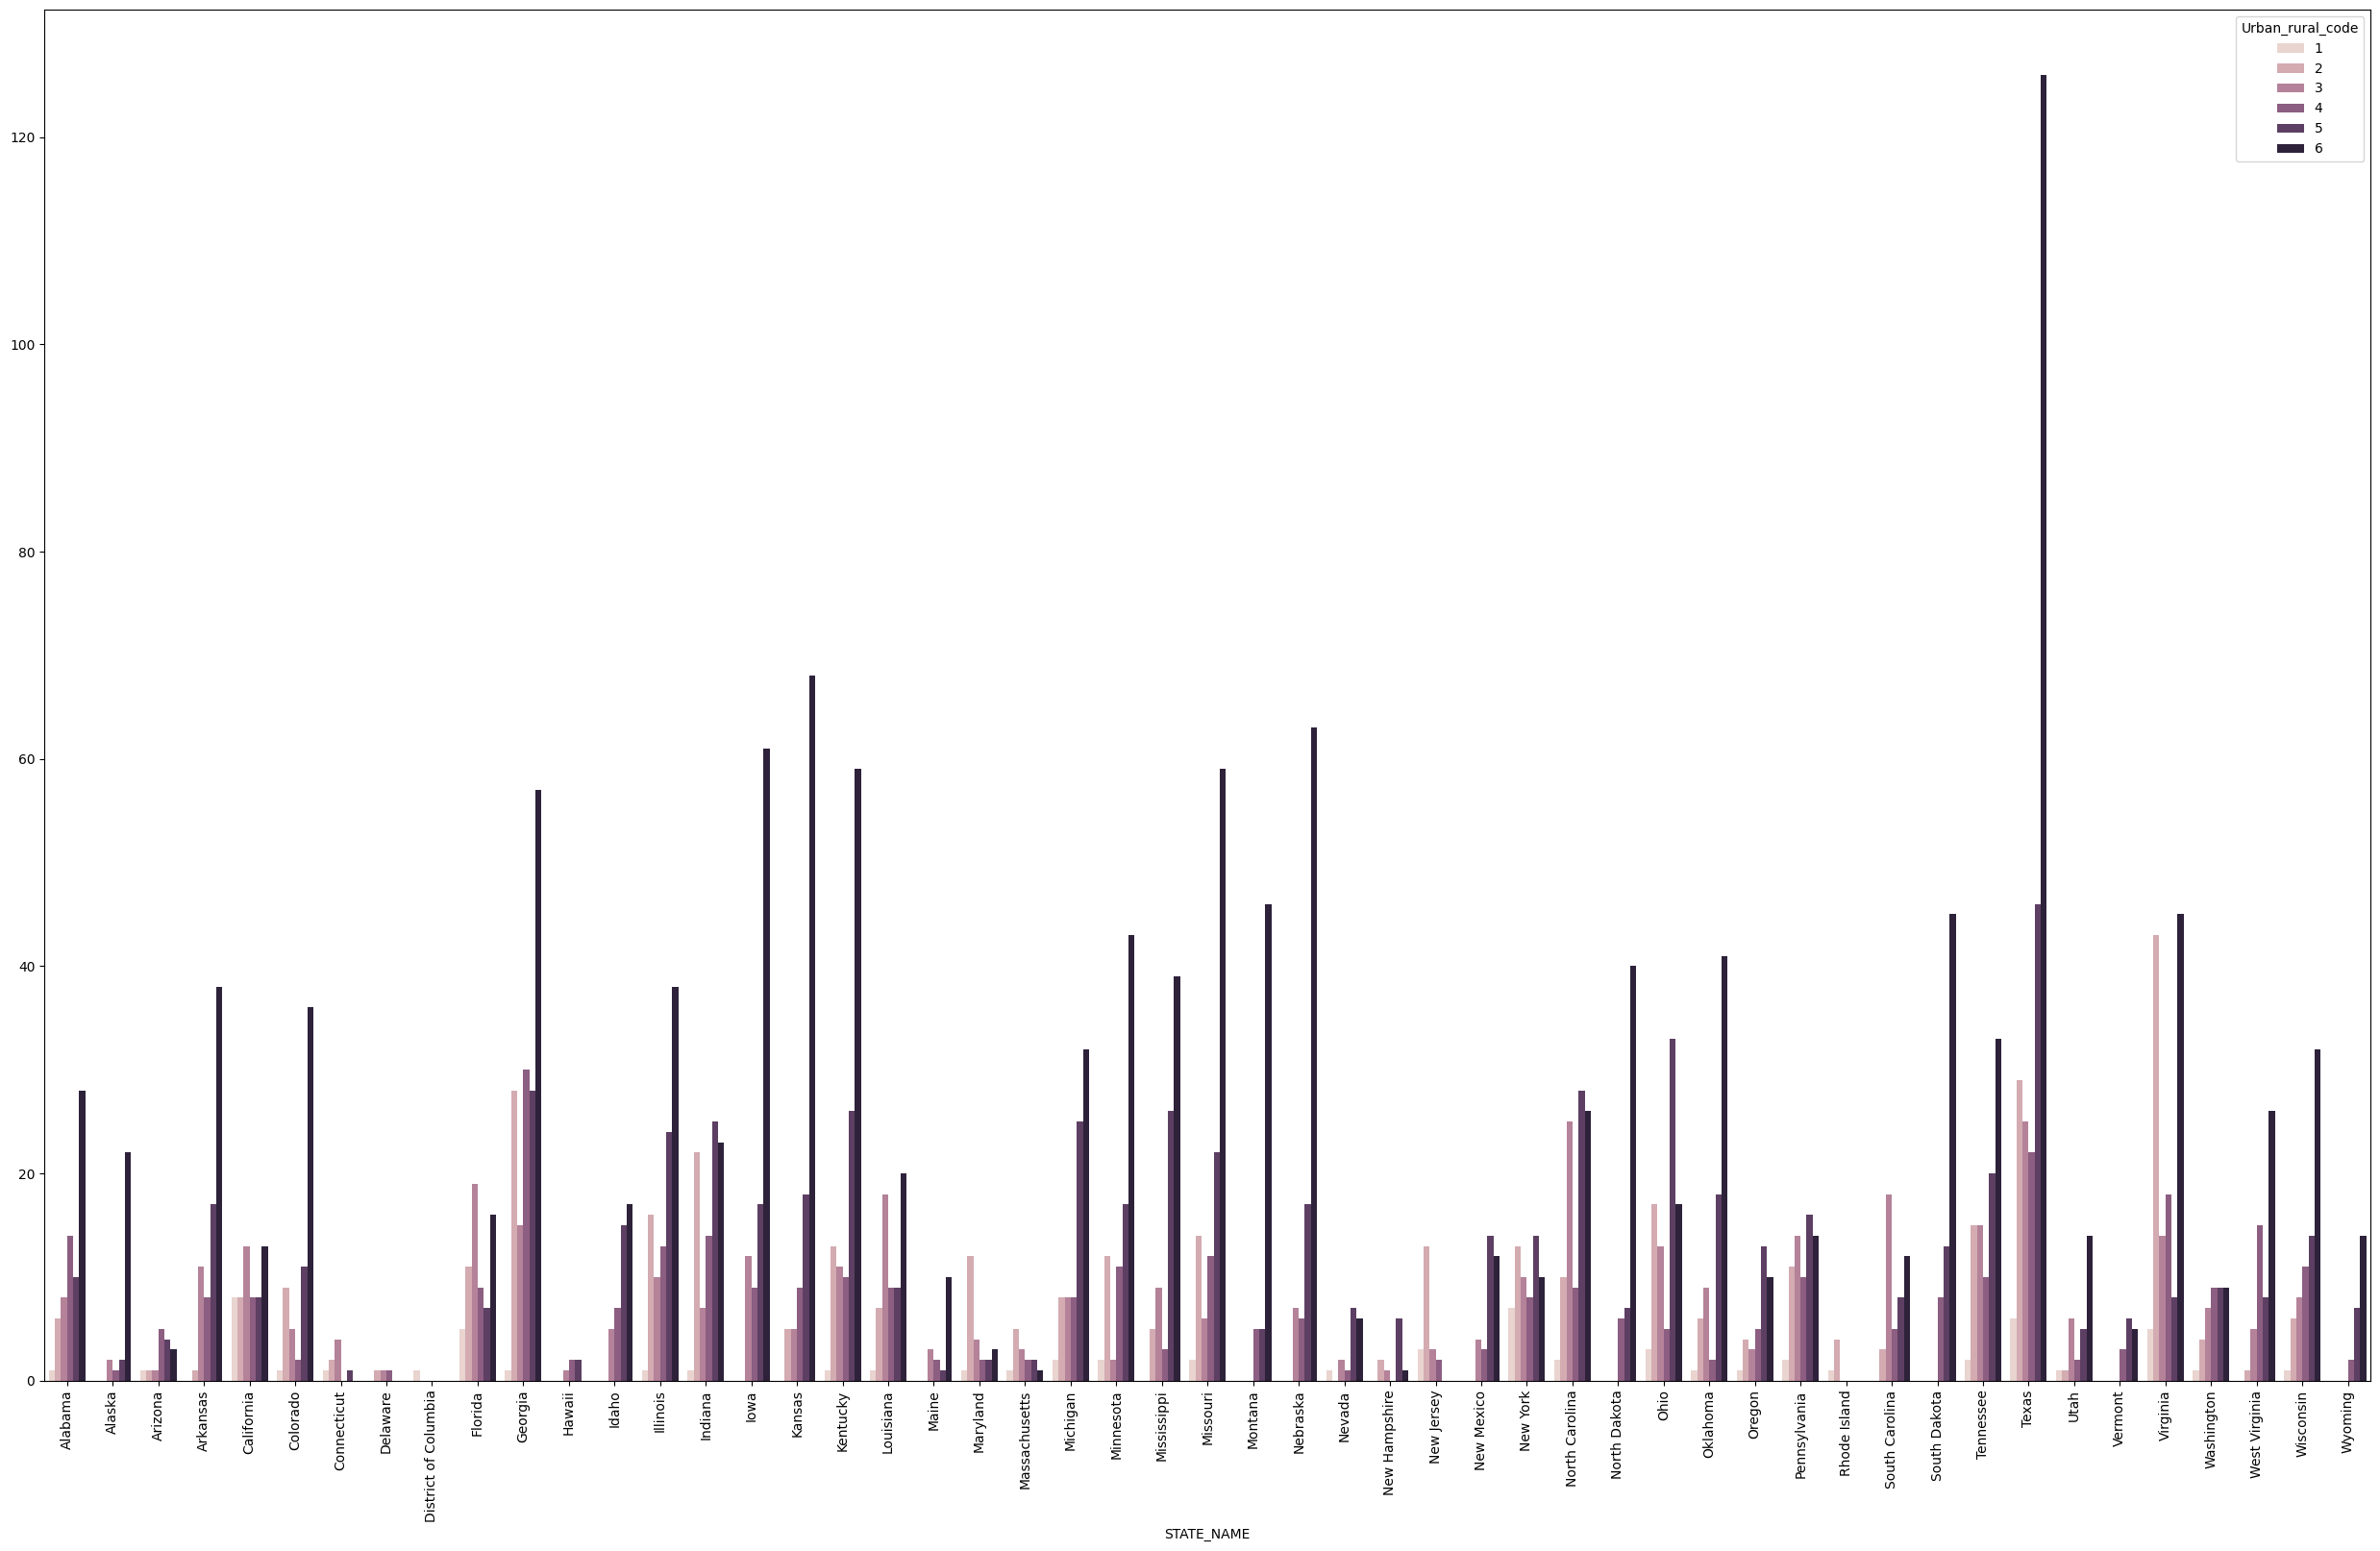

In [82]:
fig, axis = plt.subplots(1, 1, figsize=(25, 15))


sns.countplot(
    data=raw_data,
    x=categorical_variables[0],
    hue="Urban_rural_code",
).set(ylabel=None)

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

There are few enough categorical variableds here that we don't have more plots in this section.  Pretty intuitive to see Rhode Island has few if any large-population counties & Texas has plenty more people adjacent to cities.

#### Correlation analysis


['STATE_NAME', 'Urban_rural_code']


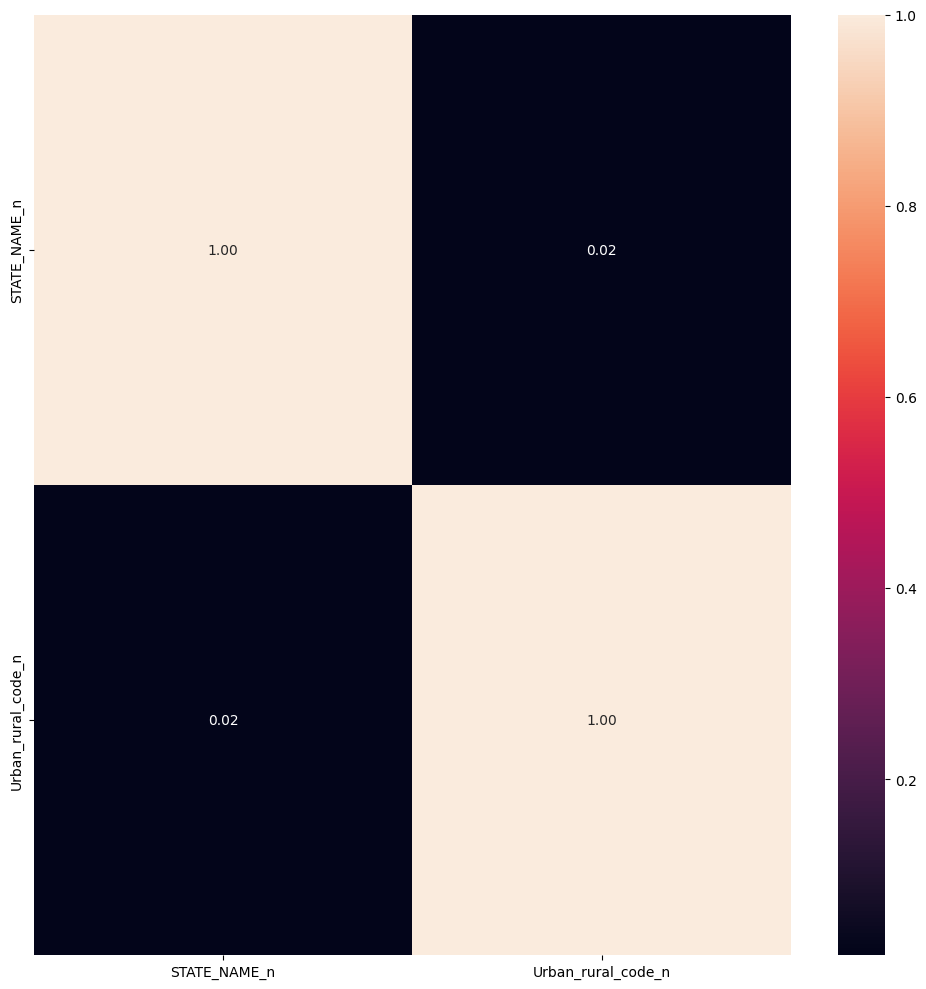

In [83]:
print(categorical_variables)
raw_data["STATE_NAME_n"] = pd.factorize(raw_data["STATE_NAME"])[0]
raw_data["Urban_rural_code_n"] = pd.factorize(raw_data["Urban_rural_code"])[0]


fig, axis = plt.subplots(figsize=(10, 10))

sns.heatmap(
    raw_data[["STATE_NAME_n", "Urban_rural_code_n"]].corr(),
    annot=True,
    fmt=".2f",
)


plt.tight_layout()

plt.show()

Not many categorical variables to talk about, and not much correlation between them; my interpretation is that all states have a variety of urban-density-types recorded.

### numerical-categorical analysis

In [ ]:
# commenting this block out because with this many features, professor recommended that rather than measuring correltation between every feature and every other feature,
# makes more sense to focus on correlations between every feature and our ytarget

# numerical_categorical_analysis_df = raw_data.drop(labels=categorical_variables, axis=1)
#
# fig, axis = plt.subplots(figsize=(30, 20))
#
# sns.heatmap(
#    raw_data[list(numerical_categorical_analysis_df.columns)].corr(),
#    annot=True,
#    fmt=".2f",
# )
#
# corr = numerical_categorical_analysis_df.corr()
#
#
# plt.tight_layout()
#
# plt.show()

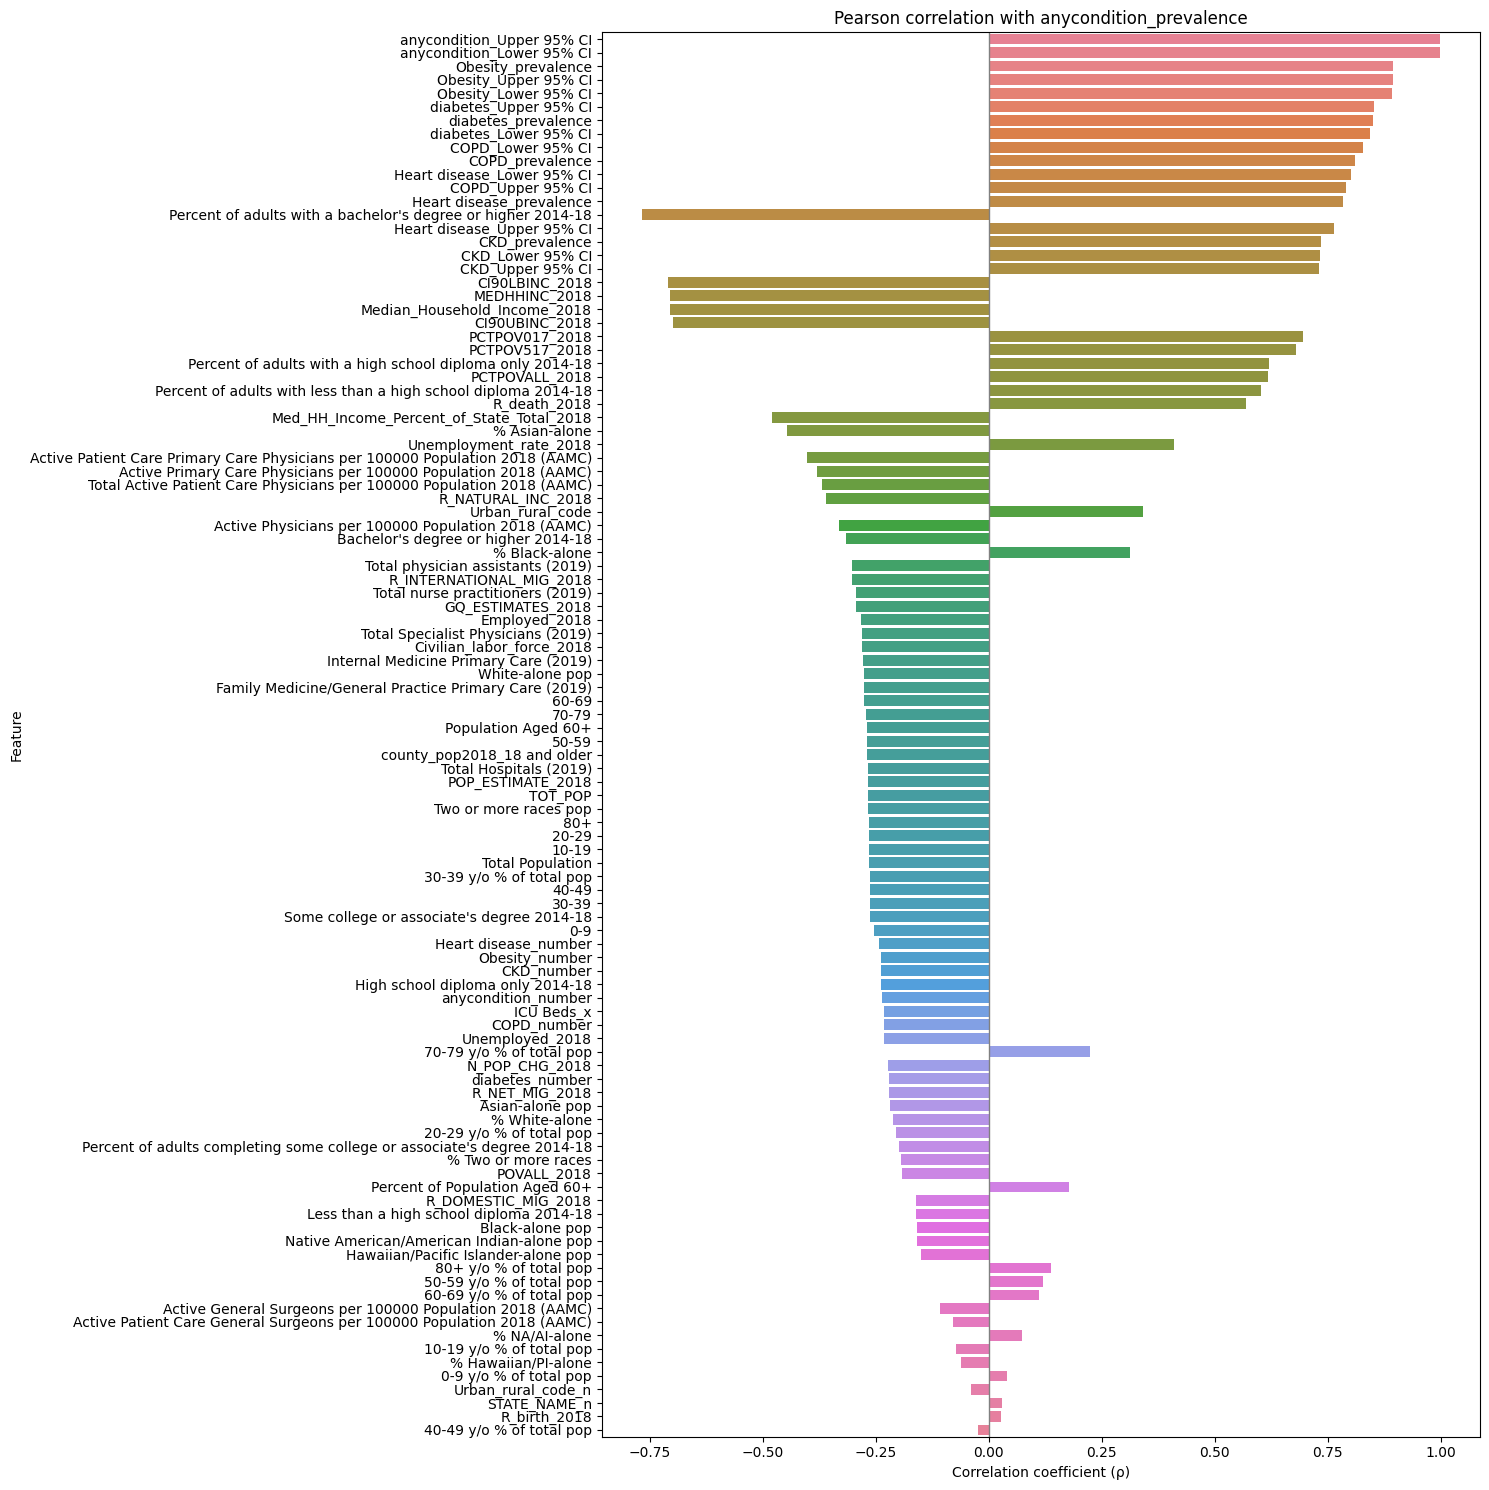

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_categorical_analysis_df = raw_data.drop(labels=categorical_variables, axis=1)

target = "anycondition_prevalence"

# faster one‑liner that skips the full × full matrix
corr = (
    raw_data.corr(numeric_only=True)[  # Pearson by default
        target
    ]  # keep only the target column
    .drop(target)  # drop self‑correlation (==1.0)
    .sort_values(key=abs, ascending=False)  # strongest ‖ρ‖ on top
)


plt.figure(figsize=(15, 15))
sns.barplot(y=corr.index, x=corr.values, orient="h", hue=corr.index, legend=False)
plt.axvline(0, color="grey", lw=1)
plt.title("Pearson correlation with anycondition_prevalence")
plt.xlabel("Correlation coefficient (ρ)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Asked ChatGPT for an alternative to the heatmap and it recommended the above style of bar chart to measure correlations against anycondition_prevalence instead.

Looks like there are stronger correlations between "anycondition_prevalence" and either percentages of people older than 60 years old, a subset of non-white singular-ethnicity-alone populations (Including Black-alone, or Hawaiian/Pacific Islander-alone), higher unemployment rates, or less-than-bachelors'-degree educational backgrounds.  There are inverse correlations between "anycondition_prevalence" and having a bachelor's degree or higher, a higher median household income, or % Asian-alone populations.

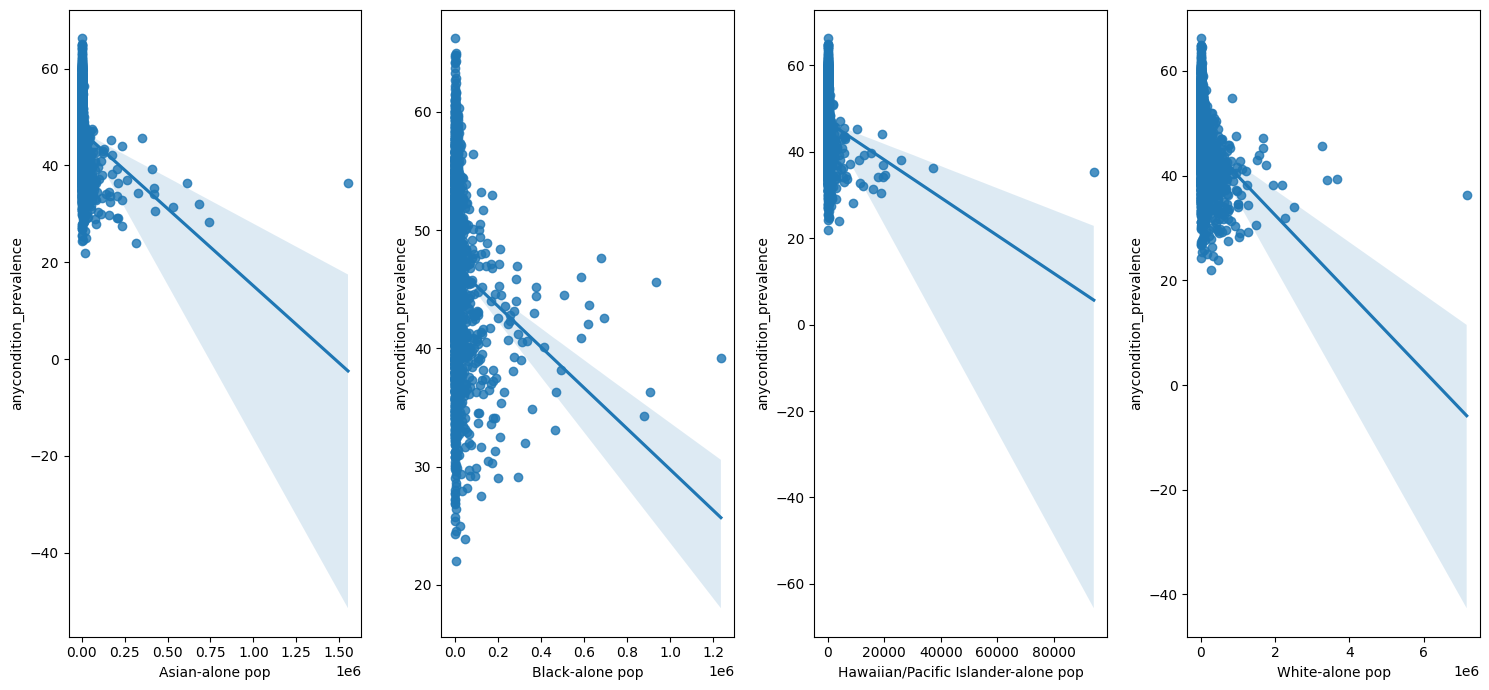

In [86]:
fig, axis = plt.subplots(figsize=(15, 7), ncols=4)

sns.regplot(ax=axis[0], data=raw_data, x="Asian-alone pop", y="anycondition_prevalence")
sns.regplot(ax=axis[1], data=raw_data, x="Black-alone pop", y="anycondition_prevalence")
sns.regplot(
    ax=axis[2],
    data=raw_data,
    x="Hawaiian/Pacific Islander-alone pop",
    y="anycondition_prevalence",
)
sns.regplot(ax=axis[3], data=raw_data, x="White-alone pop", y="anycondition_prevalence")

plt.tight_layout()

plt.show()

Based on these regression plots:
- As any of these ethnicity-alone populations inccrease, prevalence of anycondition appears to decrease.  The trendline for the Asian-alone population chart seems to contradict with the inverse correlation I thought I'd seen in the bar chart above, which I haven't found a clear explanation for yet.
- This sounds opposite an observation I made earlier until I realized earlier I was looking at anycondition_number, which would likely incrase as population does, ihnstead of anycondition_prevalence, which is a figure scaled by or divided by the population count overall, and so it makes sense for that calculation to go getting lower as people (presumably not _all_ sick all the time) are added

In [87]:
# sns.pairplot(data=raw_data) #pairplot takes a long time to render, so commenting out for the sake of notebook re-run speed

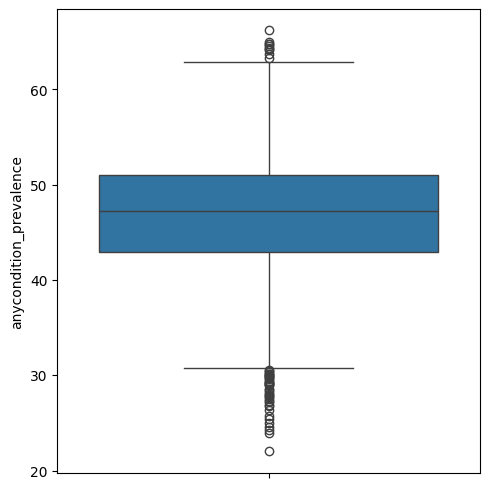

In [88]:
fig, axis = plt.subplots(1, 1, figsize=(5, 5))

sns.boxplot(data=raw_data, y="anycondition_prevalence")


plt.tight_layout()
plt.show()


Learned this lesson: limit this portion of EDA to y targets rather than trying to eliminate rows based on outliers of independent variables (generally).

Maintain-eliminate-replace decisions: Most counties have anycondition_prevalence ranging from a little less than 45 to a little over 50; 

In [89]:
# Step 1: Compute Q1 and Q3
Q1 = raw_data["anycondition_prevalence"].quantile(0.25)
Q3 = raw_data["anycondition_prevalence"].quantile(0.75)

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Filter out outliers
df_filtered = raw_data[
    (raw_data["anycondition_prevalence"] >= lower_bound)
    & (raw_data["anycondition_prevalence"] <= upper_bound)
]

print("Original Data:")
print(raw_data)
print("\nFiltered Data (Outliers Removed):")
print(df_filtered)

Original Data:
      TOT_POP    0-9  0-9 y/o % of total pop  10-19  10-19 y/o % of total pop  \
0       55601   6787               12.206615   7637                 13.735364   
1      218022  24757               11.355276  26913                 12.344167   
2       24881   2732               10.980266   2960                 11.896628   
3       22400   2456               10.964286   2596                 11.589286   
4       57840   7095               12.266598   7570                 13.087828   
...       ...    ...                     ...    ...                       ...   
3135    43051   6104               14.178532   6326                 14.694200   
3136    23081   2384               10.328842   2185                  9.466661   
3137    20299   3121               15.375142   3205                 15.788955   
3138     7885    858               10.881420   1113                 14.115409   
3139     6967    780               11.195637    779                 11.181283   

      20-29 

### Building regularized linear regression model

#### Feature scaling
##### Splitting training vs test data

In [90]:
from sklearn.model_selection import train_test_split

num_variables = numeric_variables

# We divide the dataset into training and test samples
X = raw_data[numeric_variables]
y = raw_data["anycondition_prevalence"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()

,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,...,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number
1292,26625,3221,12.097653,3463,13.006573,2922,10.974648,2829,10.625352,2831,...,13.0,2314,13.7,12.6,14.9,2823,3.8,3.5,4.1,771
2302,51266,5272,10.283619,5751,11.217961,5137,10.020286,5341,10.418211,5880,...,11.5,4097,13.1,11.9,14.2,5416,3.5,3.2,3.8,1454
761,37779,3915,10.362900,5118,13.547209,6202,16.416528,4363,11.548744,4451,...,10.4,2792,12.2,11.2,13.1,3698,2.9,2.7,3.1,871
2194,91984,11163,12.135806,12646,13.748043,11595,12.605453,11357,12.346712,11444,...,9.3,5716,11.2,10.4,12.0,7913,3.0,2.8,3.2,2118
1241,134487,16698,12.416070,17666,13.135842,17281,12.849569,15993,11.891856,15845,...,11.0,10002,12.5,11.7,13.4,12987,3.4,3.2,3.6,3490


In [91]:
# normalization scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=num_variables)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=num_variables)

X_train_norm.head()

,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,...,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number
1292,-0.229763,-0.225393,0.102383,-0.231350,0.162374,-0.229775,-0.429454,-0.223780,-0.665485,-0.228216,...,0.989521,-0.222477,0.244361,0.209312,0.314479,-0.215940,0.644725,0.576430,0.657452,-0.216950
2302,-0.161280,-0.179851,-0.754597,-0.181109,-0.836073,-0.188375,-0.736296,-0.176225,-0.785934,-0.163303,...,0.413368,-0.117073,0.021661,-0.060621,0.064137,-0.135257,0.109985,0.000382,0.161947,-0.135212
761,-0.198764,-0.209983,-0.717144,-0.195009,0.464170,-0.168470,1.320194,-0.194740,-0.128551,-0.193726,...,-0.009144,-0.194220,-0.312388,-0.330555,-0.329256,-0.188714,-0.959495,-0.959698,-0.994232,-0.204982
2194,-0.048115,-0.049041,0.120407,-0.029705,0.576280,-0.067671,0.094875,-0.062335,0.335452,-0.044847,...,-0.431656,-0.021363,-0.683554,-0.639050,-0.722650,-0.057561,-0.781249,-0.767682,-0.829064,-0.055748
1241,0.070012,0.073864,0.252809,0.080526,0.234535,0.038603,0.173362,0.025430,0.070962,0.048850,...,0.221317,0.232009,-0.201038,-0.137745,-0.221967,0.100319,-0.068262,0.000382,-0.168390,0.108446


In [92]:
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index=X_train.index, columns=num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index=X_test.index, columns=num_variables)

X_train_scal.head()

,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,...,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number
1292,0.002626,0.002666,0.484236,0.002795,0.558117,0.001877,0.316717,0.001876,0.280961,0.002094,...,0.491620,0.005315,0.395833,0.381720,0.414141,0.002953,0.441860,0.425,0.456522,0.003230
2302,0.005064,0.004363,0.411625,0.004641,0.481367,0.003299,0.289175,0.003549,0.268121,0.004352,...,0.407821,0.009422,0.364583,0.344086,0.378788,0.005676,0.372093,0.350,0.391304,0.006103
761,0.003730,0.003240,0.414798,0.004130,0.581316,0.003983,0.473765,0.002898,0.338200,0.003294,...,0.346369,0.006416,0.317708,0.306452,0.323232,0.003872,0.232558,0.225,0.239130,0.003651
2194,0.009094,0.009239,0.485763,0.010205,0.589934,0.007447,0.363781,0.007555,0.387664,0.008474,...,0.284916,0.013152,0.265625,0.263441,0.267677,0.008298,0.255814,0.250,0.260870,0.008895
1241,0.013300,0.013820,0.496981,0.014257,0.563664,0.011098,0.370826,0.010642,0.359468,0.011733,...,0.379888,0.023026,0.333333,0.333333,0.338384,0.013626,0.348837,0.350,0.347826,0.014666


In [93]:
# feature selection for selecting most-relevant features to use for building ML model

from sklearn.feature_selection import f_classif, SelectKBest

# With a value of k = 16 we implicitly mean that we want to remove 4 features from the 20-column dataset
selection_model = SelectKBest(f_classif, k=16)
selection_model.fit(X_train_scal, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(
    selection_model.transform(X_train), columns=X_train.columns.values[ix]
)
X_test_sel = pd.DataFrame(
    selection_model.transform(X_test), columns=X_test.columns.values[ix]
)

X_train_sel.head()

,Percent of adults with a bachelor's degree or higher 2014-18,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI
0,18.8,49.7,47.3,51.9,38.6,36.8,40.4,10.1,9.1,11.1,11.3,9.6,13.0,13.7,12.6,14.9
1,17.6,46.7,44.0,49.2,33.2,31.3,35.1,9.2,8.2,10.1,9.9,8.3,11.5,13.1,11.9,14.2
2,16.1,47.0,44.9,49.1,33.7,32.1,35.4,7.3,6.6,8.1,9.2,7.9,10.4,12.2,11.2,13.1
3,24.3,46.9,44.9,48.7,36.5,35.1,38.1,7.8,7.1,8.5,8.1,7.1,9.3,11.2,10.4,12.0
4,21.2,48.0,46.0,49.8,37.5,36.1,39.0,8.4,7.7,9.1,9.6,8.4,11.0,12.5,11.7,13.4


In [94]:
X_train_sel["anycondition_prevalence"] = list(y_train)
X_test_sel["anycondition_prevalence"] = list(y_test)

In [95]:
X_train_sel.to_csv(
    "../data/interim/clean_socioeconomic_health_train.csv",
    index=False,
)
X_test_sel.to_csv("../data/interim/clean_socioeconomic_health_test.csv", index=False)

In [96]:
import pandas as pd

train_data = pd.read_csv("../data/interim/clean_socioeconomic_health_train.csv")
test_data = pd.read_csv("../data/interim/clean_socioeconomic_health_test.csv")

train_data.head()

,Percent of adults with a bachelor's degree or higher 2014-18,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI
0,18.8,49.7,47.3,51.9,38.6,36.8,40.4,10.1,9.1,11.1,11.3,9.6,13.0,13.7,12.6,14.9
1,17.6,46.7,44.0,49.2,33.2,31.3,35.1,9.2,8.2,10.1,9.9,8.3,11.5,13.1,11.9,14.2
2,16.1,47.0,44.9,49.1,33.7,32.1,35.4,7.3,6.6,8.1,9.2,7.9,10.4,12.2,11.2,13.1
3,24.3,46.9,44.9,48.7,36.5,35.1,38.1,7.8,7.1,8.5,8.1,7.1,9.3,11.2,10.4,12.0
4,21.2,48.0,46.0,49.8,37.5,36.1,39.0,8.4,7.7,9.1,9.6,8.4,11.0,12.5,11.7,13.4


In [97]:
X_train = train_data.drop(["anycondition_prevalence"], axis=1)
y_train = train_data["anycondition_prevalence"]
X_test = test_data.drop(["anycondition_prevalence"], axis=1)
y_test = test_data["anycondition_prevalence"]

In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1, max_iter=300)

lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e+01, tolerance: 1.022e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# commenting ridge model block out so we can focus on lasso model today

# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error, r2_score
#
#
# ridge_model = Ridge(alpha=0.1, max_iter=300)
#
# ridge_model.fit(X_train, y_train)
#
# y_pred = ridge_model.predict(X_test)
#
#
# print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 0.00418586467311586
Coefficient of determination: 0.9998970379957267


#### Analyzing how R2 changes as model hyperparameter changes

In [107]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 0.004820528872253548
Coefficient of determination: 0.9998814268130711


#### Hyperparameter optimizing
##### Visualizing r-squared score as alpha is changed

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e+01, tolerance: 1.022e+01
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+01, tolerance: 1.022e+01
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

,alpha,r2
0,1,0.999310
1,2,0.997475
2,3,0.994377
3,4,0.990015
4,5,0.984390
5,6,0.977501
6,7,0.969349
7,8,0.959934
8,9,0.949256
9,10,0.937314


Best R²: alpha    1.00000
r2       0.99931
Name: 0, dtype: float64


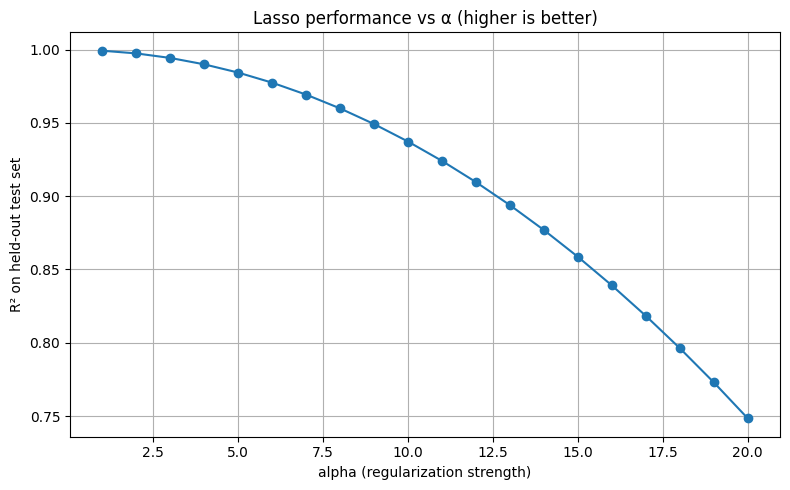

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# generated by asking ChatGPT model o3 the following:
# "Given the following code which displays the mean squared error and r2 score (coefficient of determination) for a Lasso model built with default "alpha" regularization hyperparameter...
# "teach me how to design and implement the subsequent jupyter notebook cell or cells necessary to try building and assessing r2 score for lasso models based upon the same data ranging from an alpha of 1 all the way up to an alpha of 20, charting the r2 value of each in a line diagram."

alphas = np.arange(1, 21)  # 1 … 20 inclusive
r2_scores = []

for a in alphas:
    model = Lasso(alpha=a, max_iter=300, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# ----- quick inspection table (optional) -----
results = pd.DataFrame({"alpha": alphas, "r2": r2_scores})
display(results)  # Jupyter will show a neat table
print("Best R²:", results.loc[results.r2.idxmax()])

# ----- line chart -----
plt.figure(figsize=(8, 5))
plt.plot(alphas, r2_scores, marker="o")
plt.title("Lasso performance vs α (higher is better)")
plt.xlabel("alpha (regularization strength)")
plt.ylabel("R² on held‑out test set")
plt.grid(True)
plt.tight_layout()
plt.show()


Given those findings, by the time we reach an alpha of 20 the r-squared value has not only decreased noticeably, but the rate of decrease is becoming greater as alpha gets larger.